# Noisy gridworld

In [1]:
import agents
import gridworld
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from tqdm import tqdm
from copy import deepcopy
from itertools import product
from numba import njit, prange

In [2]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

plt.rcParams["font.size"] = 14

In [3]:
n_rows = 4
n_cols = 12

In [4]:
movements = np.array([
    [0, 1], # right
    [0, -1], # left
    [1, 0], # down,
    [-1, 0], # up
    # [0, 0], # nothing
])
n_actions = len(movements)

name_movements = ["right", "left", "down", "up"]
# name_movements = ["right", "left", "down", "up", "nothing"]

map_movements = {n: move for n, move in enumerate(name_movements)}

In [59]:
start_ix = 36
end_ix = 47
reward_goal =  100
G = gridworld.CliffGridworld(
    start_ix, end_ix, n_rows, n_cols, reward_goal, has_noisy_reward=True
)

In [75]:
n_steps = 50_000
n_steps = 100_000
epsilon = 0.1
alpha = 0.5
gamma = 1.0

seed = 314
# SARSA
hist_sarsa, Q_sarsa = agents.run_agent(
    start_ix, G, n_actions, n_steps, epsilon, alpha, gamma, movements,
    agents.sarsa_step_and_update,
    seed=seed
)

# Double Q-learning
Q_doubleqlearn = np.zeros((2, G.n_states, n_actions))
hist_doubleqlearn, Q_doubleqlearn = agents.run_agent(
    start_ix, G, n_actions, n_steps, epsilon, alpha, gamma, movements,
        agents.double_q_learning_step_and_update,
    Q=Q_doubleqlearn
)


# Q learning
hist_qlearn, Q_qlearn = agents.run_agent(
    start_ix, G, n_actions, n_steps, epsilon, alpha, gamma, movements,
    agents.qlearning_step_and_update,
)


# Expected SARSA
hist_expected_sarsa, Q_expected_sarsa = agents.run_agent(
    start_ix, G, n_actions, n_steps, epsilon, alpha, gamma, movements,
    agents.expected_sarsa_step_and_update
)


hist = {
    "sarsa": deepcopy(hist_sarsa),
    "q": deepcopy(hist_qlearn),
    "double-q": deepcopy(hist_doubleqlearn),
    "expected_sarsa": deepcopy(hist_expected_sarsa)
}

del hist_qlearn, hist_sarsa, hist_expected_sarsa

In [76]:
hist["sarsa"]["reward"][-500:].mean()

0.2596307864669767

In [77]:
hist["q"]["reward"][-500:].mean()

3.069976179412155

In [78]:
hist["double-q"]["reward"][-500:].mean()

-1.2519613308427529

In [79]:
hist["expected_sarsa"]["reward"][-500:].mean()

3.011467572896145

In [80]:
for key in hist:
    n_episodes_visited = len(np.where(hist[key]["reward"] == reward_goal)[0])
    print(f"{key:15} - {n_episodes_visited:03}")

sarsa           - 1963
q               - 4538
double-q        - 801
expected_sarsa  - 4974


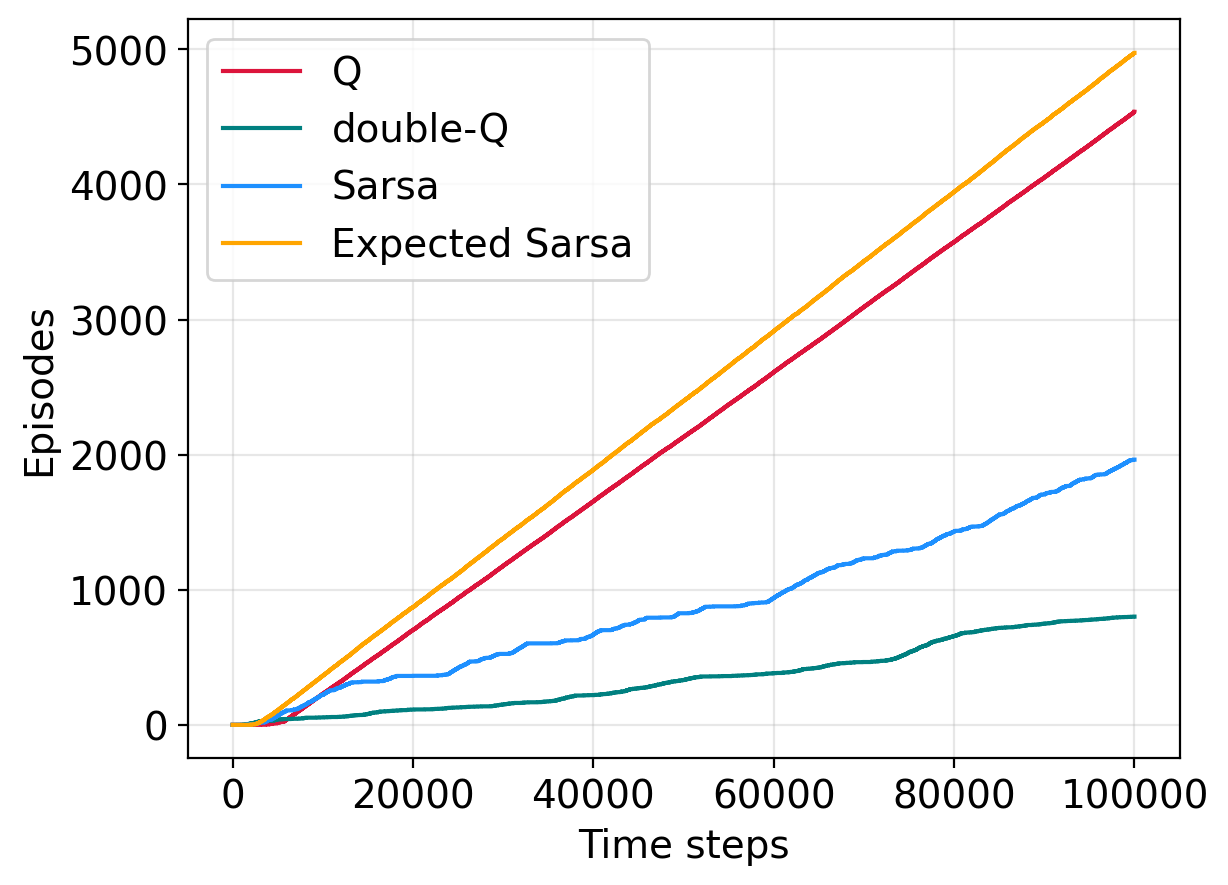

In [81]:
plt.plot((hist["q"]["reward"] == reward_goal).cumsum(), c="crimson", label="Q")
plt.plot((hist["double-q"]["reward"] == reward_goal).cumsum(), c="teal", label="double-Q")
plt.plot((hist["sarsa"]["reward"] == reward_goal).cumsum(), c="dodgerblue", label="Sarsa")
plt.plot((hist["expected_sarsa"]["reward"] == reward_goal).cumsum(), c="orange", label="Expected Sarsa")

plt.legend()
plt.grid(alpha=0.3)
plt.xlabel("Time steps")
plt.ylabel("Episodes");

In [82]:
markers = {
    "down": "v",
    "up": "^",
    "right": ">",
    "left": "<",
    "nothing": "o"
}

In [83]:
def plot_agent_run(
    ax, hist_agent, run, gridworld, reward_goal,
    c_line="black", c_arrow="crimson", show_step=False
):
    ix_goal = np.where(hist_agent["reward"] == reward_goal)[0]
    pos_hist = np.c_[hist_agent["ix"] % gridworld.n_cols, hist_agent["ix"] // gridworld.n_cols]
    iinit = ix_goal[run] + 1
    iend = ix_goal[run + 1] + 1
    
    subhist_action = hist_agent["action"][iinit:iend]
    subhist_action = [name_movements[a] for a in subhist_action]
    subhist_action = [markers[action] for action in subhist_action]
    
    subhist_pos = pos_hist[iinit:iend]
    
    ax.plot(*subhist_pos.T, c=c_line, linestyle="--")
    
    for i, ((x,y), m) in enumerate(zip(subhist_pos, subhist_action)):
        ax.scatter(x, y, marker=m, zorder=3, s=50, c=c_arrow)
        if show_step:
            ax.text(x, y, i, verticalalignment="bottom", horizontalalignment="left")


def plot_gridworld_board(ax, gridworld):
    xticks = np.arange(gridworld.n_cols)
    yticks = np.arange(gridworld.n_rows)
    ax.set(
        xticks=xticks + 0.5,
        yticks=yticks + 0.5,
        xticklabels="",
        yticklabels="",
    )
    ax.set_xticks(xticks, labels=xticks, minor=True)
    ax.set_yticks(yticks, labels=yticks, minor=True)
    
    ax.set_ylim(-0.5, gridworld.n_rows - 0.5)
    ax.set_xlim(-0.5, gridworld.n_cols - 0.5)
    ax.invert_yaxis()
    
    for i, (r, c) in enumerate(product(range(gridworld.n_rows), range(gridworld.n_cols))):
        ax.text(c, r, i, c="tab:gray", zorder=0, fontsize=6)
    
    ax.grid(alpha=0.3)

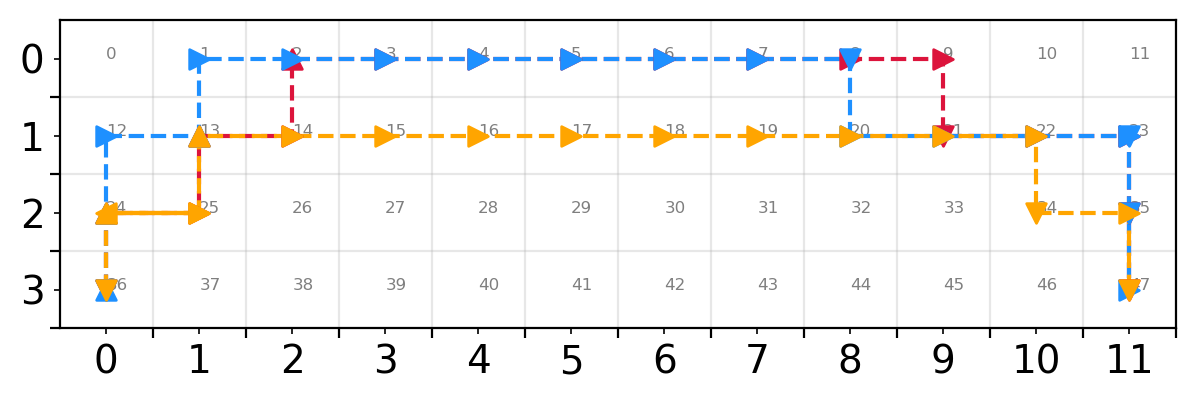

In [84]:
fig, ax = plt.subplots(figsize=(n_cols * 0.6, n_rows * 0.5))

plot_gridworld_board(ax, G)

ix_run = -2
plot_agent_run(ax, hist["q"], ix_run, G, reward_goal, c_line="crimson")
plot_agent_run(ax, hist["sarsa"], ix_run, G, reward_goal, c_line="dodgerblue", c_arrow="dodgerblue")
plot_agent_run(ax, hist["expected_sarsa"], ix_run, G, reward_goal, c_line="orange", c_arrow="orange")

In [85]:
np.array([markers[map_movements[a]] for a in Q_qlearn.argmax(axis=1)]).reshape(G.n_rows, G.n_cols)

array([['v', '<', '>', '>', '>', '>', '>', '>', '>', 'v', 'v', 'v'],
       ['>', '>', '^', '^', '^', '^', '<', '>', '>', '>', '>', 'v'],
       ['>', '^', '<', '^', '^', 'v', '>', '^', 'v', '>', '>', 'v'],
       ['^', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', 'v']],
      dtype='<U1')

In [86]:
np.array([markers[map_movements[a]] for a in Q_sarsa.argmax(axis=1)]).reshape(G.n_rows, G.n_cols)

array([['>', '>', '>', '>', '>', '>', '^', '<', '>', 'v', '<', '<'],
       ['>', '^', '<', '^', '>', '^', '^', '^', '>', '>', '>', 'v'],
       ['^', '^', '>', '^', '<', '^', '^', '^', '^', '<', '^', 'v'],
       ['^', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>']],
      dtype='<U1')

In [87]:
np.array([markers[map_movements[a]] for a in Q_expected_sarsa.argmax(axis=1)]).reshape(G.n_rows, G.n_cols)

array([['v', '>', 'v', '>', 'v', '>', '>', 'v', '<', '>', 'v', 'v'],
       ['v', '>', '>', '>', '>', '>', '>', '>', '>', '>', 'v', 'v'],
       ['>', '^', '^', '>', '^', '>', '^', '>', '>', '^', '>', 'v'],
       ['^', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', 'v']],
      dtype='<U1')

In [93]:
# ?? looks weird
np.array([markers[map_movements[a]] for a in Q_doubleqlearn.mean(axis=0).argmax(axis=1)]).reshape(G.n_rows, G.n_cols)

array([['>', '<', '>', '^', '>', '>', '>', '^', '>', '^', '>', 'v'],
       ['^', '^', '^', '>', '>', 'v', '^', '<', '>', '>', '^', 'v'],
       ['^', '<', '^', 'v', '>', '<', '<', '^', '^', '<', '^', 'v'],
       ['^', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>']],
      dtype='<U1')

## Multiple runs

In [125]:
def sims_agent(step_update_fn, alpha, n_episodes, n_simulations):
    simulations_return = agents.simulations_run_agent_return(
        start_ix, G, n_actions, n_episodes, epsilon, alpha, gamma, movements,
        step_update_fn, seed=seed,
        n_simulations=n_simulations
    )
    return simulations_return

In [126]:
%%time
alpha = 0.5
n_simulations = 800
n_episodes = 500

simulations_q = sims_agent(agents.qlearning_step_and_update, alpha, n_episodes, n_simulations)
simulations_sarsa = sims_agent(agents.sarsa_step_and_update, alpha, n_episodes, n_simulations)
simulations_expected_sarsa = sims_agent(agents.expected_sarsa_step_and_update, alpha, n_episodes, n_simulations)

CPU times: user 43min 18s, sys: 3.94 s, total: 43min 22s
Wall time: 30.6 s


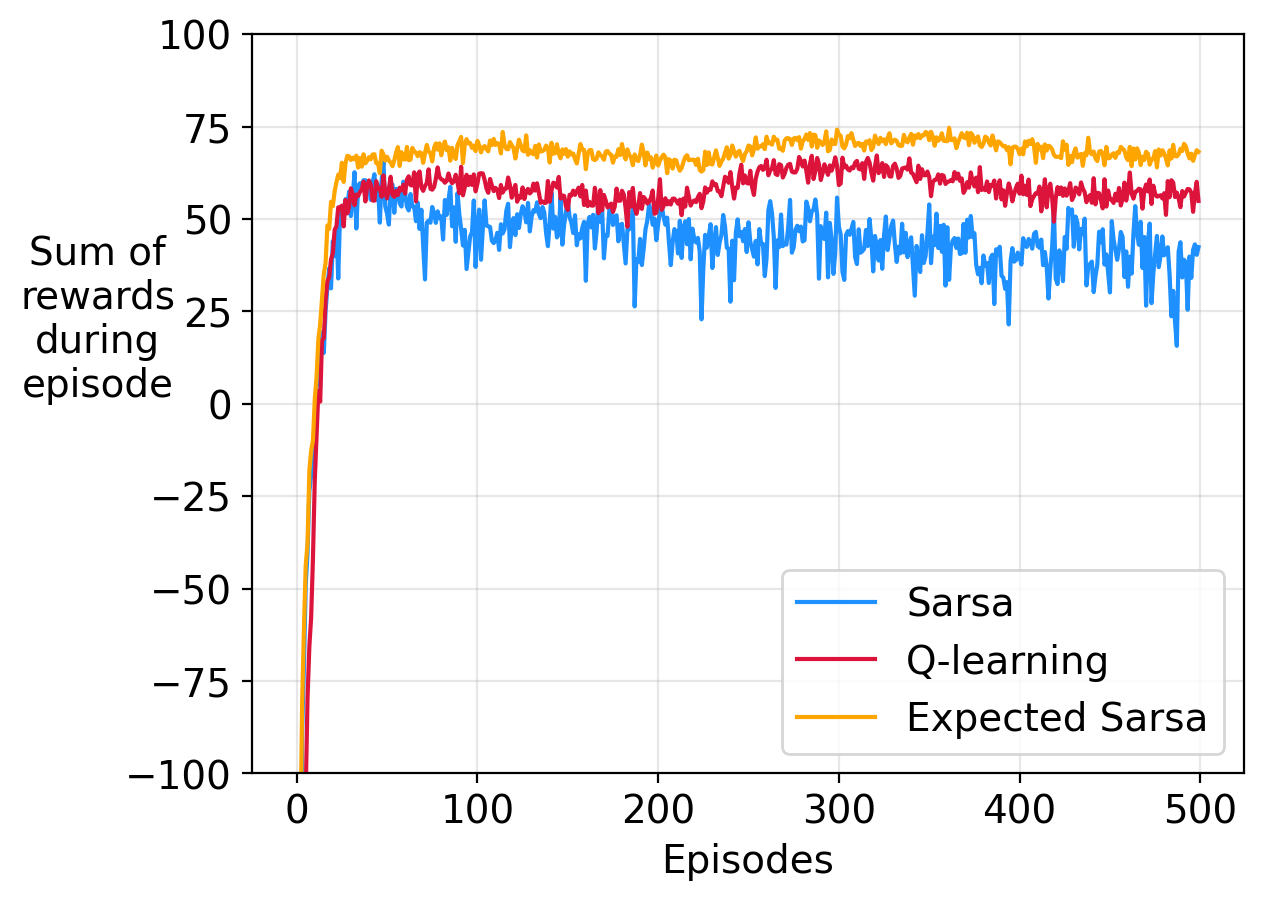

In [127]:
plt.plot(simulations_sarsa.mean(axis=0), label="Sarsa", c="dodgerblue")
plt.plot(simulations_q.mean(axis=0), label="Q-learning", c="crimson")
plt.plot(simulations_expected_sarsa.mean(axis=0), label="Expected Sarsa", c="orange")

plt.legend()
# plt.ylim(bottom=-500, top=-100)
plt.ylim(bottom=-100, top=100)
plt.xlabel("Episodes")
plt.ylabel("Sum of\nrewards\nduring\nepisode", rotation=0, labelpad=10)
plt.grid(alpha=0.3)